SETUP Environment

In [1]:
#pip install tensorflow opencv-python
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import keras

2023-12-23 19:06:53.507022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 19:06:53.507539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 19:06:54.007026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 19:06:55.318373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-23 19:07:12.556619: W tensorflow/compiler/tf2

In [2]:
gpus = tf.config.experimental.list_physical_devices('CPU')
gpus 

2023-12-23 19:09:16.832221: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

REMOVE DODGY IMAGES

In [4]:
import cv2
import imghdr

/tmp/ipykernel_16043/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [55]:
data_dir="people"
Image_exts = ['jpeg','jpg','bmp','png']

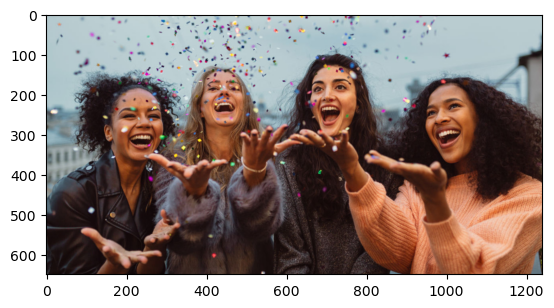

In [56]:
#show one image
img = cv2.imread(os.path.join(data_dir,"happy","35438_hd.jpg"))
img.shape
#plt.imshow(img)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

libpng warning: iCCP: known incorrect sRGB profile


(193, 262, 3)
721


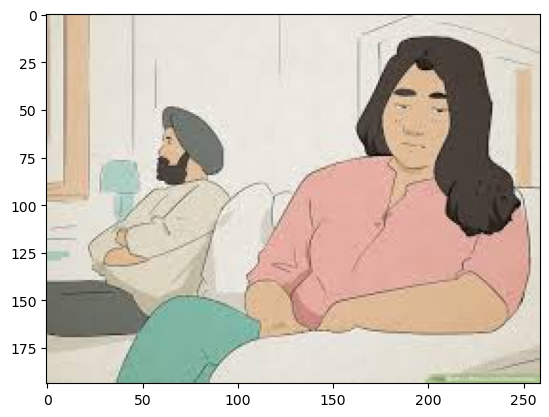

In [57]:
Image_vector = []
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir, image_class,image)
            
        imge = cv2.imread(image_path)
        
        Image_vector.append(imge)
print(imge.shape)
print(len(Image_vector))

plt.imshow(cv2.cvtColor(Image_vector[483], cv2.COLOR_BGR2RGB))

In [9]:
#os.listdir(os.path.join(data_dir,"sad"))

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir, image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            
            if tip not in Image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        
        except Exception as e:
            print('Image with image {}'.format(image_path))
        

libpng warning: iCCP: known incorrect sRGB profile


LOAD DATA

1. Load data

In [19]:
#keras.utils.image_dataset_from_directory?


In [10]:
data = keras.utils.image_dataset_from_directory(data_dir, batch_size=8, image_size=(128,128))

Found 721 files belonging to 2 classes.


2. Label data

In [11]:
data_iterator = data.as_numpy_iterator()

In [12]:
img_data, labels = data_iterator.next()

In [110]:
#num_batches = 0
#for batch in data_iterator:
 #   num_batches += 1

#print("Number of batches:", num_batches)

3. visualization

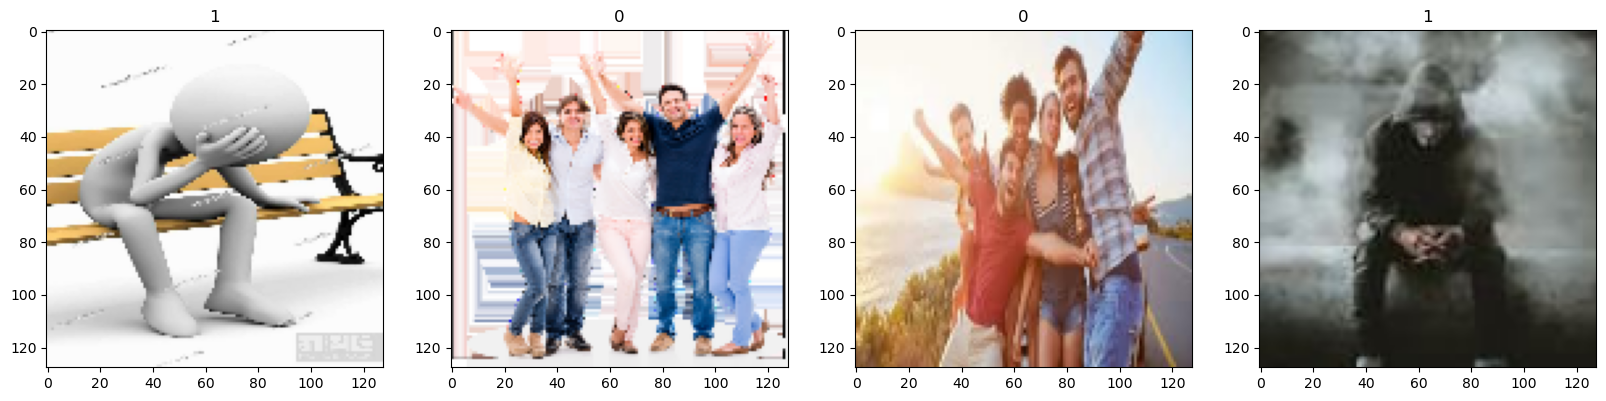

In [13]:
# Descrpition 0 : happy people, 1 : sad people
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 
for idx, img in enumerate(img_data[:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(labels[idx])

PREPROCESSING DATA

1. Scale Data

In [14]:
scaled_data = data.map(lambda x,y: (x/255,y))

2. label data

In [15]:

scaled_iterator = scaled_data.as_numpy_iterator()

In [16]:
X,y = next(scaled_iterator)

2023-12-23 19:13:51.756934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


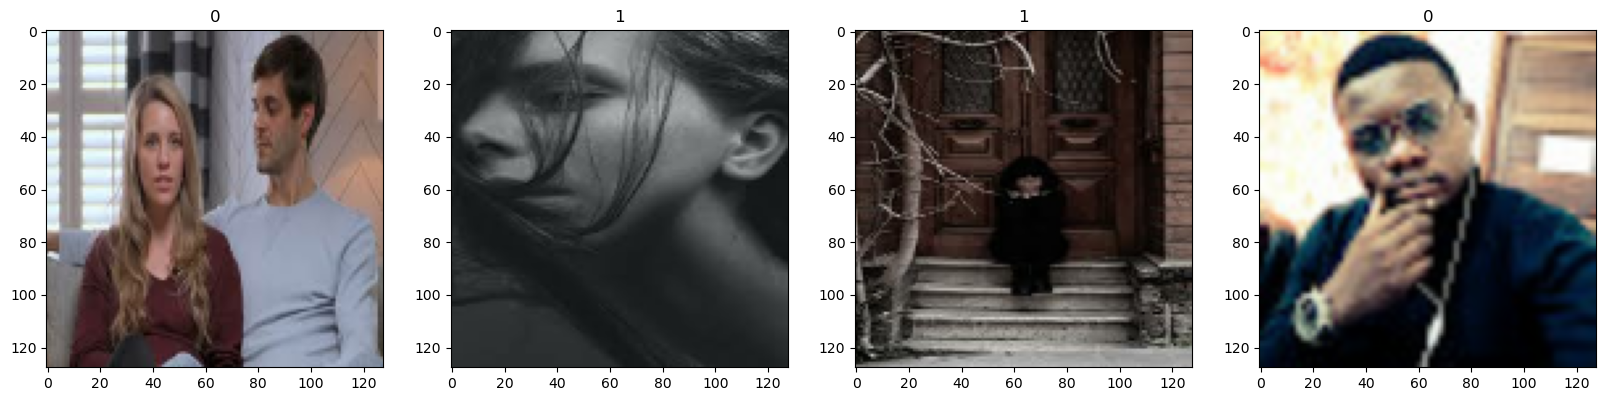

In [17]:
# Descrpition 0 : happy people, 1 : sad people
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 
for idx, img in enumerate(X[:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(y[idx])

3. Split data

In [18]:
len(scaled_data)

91

In [21]:
X[2].shape

(128, 128, 3)

In [22]:
train_size = int(len(scaled_data)*.7)
test_size  = int(len(scaled_data)*.2)
val_size  = int(len(scaled_data)*.1)+1

In [24]:
train = scaled_data.take(train_size)
val  =  scaled_data.skip(train_size).take(val_size)
test =  scaled_data.skip(train_size+val_size).take(test_size)

Deep Model

1. Build Deep Learning Model

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [26]:
#create model
model = Sequential()

In [27]:
# First Convolutional Layer
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128,128,3)))

# MaxPooling Layer
model.add(MaxPool2D())

# Second Convolutional Layer
model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPool2D())

# Third Convolutional Layer
model.add(Conv2D(128, (3,3), 1, activation='relu'))
model.add(MaxPool2D())

# Flatten Layer to convert 2D feature maps to a vector
model.add(Flatten())

# Fully Connected (Dense) Layer
model.add(Dense(128, activation='relu'))

# Consider adding dropout layers after the fully connected layers to prevent overfitting. (Optionel)
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

In [28]:
optimer = keras.optimizers.Adam(learning_rate=0.001)
model.compile("adam", loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 128)       0

2. train model

In [58]:
logdir='logs_image'
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [59]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-12-23 19:59:08.158768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9940

2023-12-23 19:59:38.199727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 36s 554ms/step - loss: 0.0283 - accuracy: 0.9940 - val_loss: 0.3318 - val_accuracy: 0.9000
Epoch 2/20


2023-12-23 19:59:43.825161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9861

2023-12-23 20:00:11.984482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 34s 531ms/step - loss: 0.0419 - accuracy: 0.9861 - val_loss: 0.3300 - val_accuracy: 0.9375
Epoch 3/20


2023-12-23 20:00:17.737465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9881

2023-12-23 20:00:42.638669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 30s 462ms/step - loss: 0.0441 - accuracy: 0.9881 - val_loss: 0.3351 - val_accuracy: 0.9000
Epoch 4/20


2023-12-23 20:00:47.366355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9940

2023-12-23 20:01:10.963130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 28s 445ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.0821 - val_accuracy: 0.9625
Epoch 5/20


2023-12-23 20:01:15.839043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0165 - accuracy: 0.9960

2023-12-23 20:01:43.889479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 34s 527ms/step - loss: 0.0165 - accuracy: 0.9960 - val_loss: 0.2667 - val_accuracy: 0.9125
Epoch 6/20


2023-12-23 20:01:56.734494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0204 - accuracy: 0.9940

2023-12-23 20:02:27.436476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 51s 815ms/step - loss: 0.0204 - accuracy: 0.9940 - val_loss: 0.2372 - val_accuracy: 0.9125
Epoch 7/20


2023-12-23 20:03:20.493186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9980

2023-12-23 20:03:55.410316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 42s 657ms/step - loss: 0.0104 - accuracy: 0.9980 - val_loss: 0.1928 - val_accuracy: 0.9125
Epoch 8/20


2023-12-23 20:04:02.197083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0155 - accuracy: 0.9921

2023-12-23 20:04:33.953998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 39s 612ms/step - loss: 0.0155 - accuracy: 0.9921 - val_loss: 0.2027 - val_accuracy: 0.9125
Epoch 9/20


2023-12-23 20:04:41.189721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9940

2023-12-23 20:05:07.691246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 31s 489ms/step - loss: 0.0220 - accuracy: 0.9940 - val_loss: 0.1433 - val_accuracy: 0.9375
Epoch 10/20


2023-12-23 20:05:12.479007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9921

2023-12-23 20:05:35.419821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 28s 434ms/step - loss: 0.0203 - accuracy: 0.9921 - val_loss: 0.1472 - val_accuracy: 0.9500
Epoch 11/20


2023-12-23 20:05:40.429545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9960

2023-12-23 20:06:03.857941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 29s 449ms/step - loss: 0.0107 - accuracy: 0.9960 - val_loss: 0.2515 - val_accuracy: 0.9125
Epoch 12/20


2023-12-23 20:06:09.226286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9960

2023-12-23 20:06:32.824895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 29s 444ms/step - loss: 0.0114 - accuracy: 0.9960 - val_loss: 0.2361 - val_accuracy: 0.9500
Epoch 13/20


2023-12-23 20:06:37.794908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9960

2023-12-23 20:07:00.975615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 28s 435ms/step - loss: 0.0102 - accuracy: 0.9960 - val_loss: 0.1455 - val_accuracy: 0.9625
Epoch 14/20


2023-12-23 20:07:05.588052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9861

2023-12-23 20:07:28.335603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 27s 429ms/step - loss: 0.0807 - accuracy: 0.9861 - val_loss: 0.2458 - val_accuracy: 0.9375
Epoch 15/20


2023-12-23 20:07:32.992349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.1277 - accuracy: 0.9544

2023-12-23 20:07:56.089116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 28s 443ms/step - loss: 0.1277 - accuracy: 0.9544 - val_loss: 0.2772 - val_accuracy: 0.9375
Epoch 16/20


2023-12-23 20:08:01.241038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.9643

2023-12-23 20:08:25.004741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 29s 457ms/step - loss: 0.1003 - accuracy: 0.9643 - val_loss: 0.2767 - val_accuracy: 0.9000
Epoch 17/20
 1/63 [..............................] - ETA: 26s - loss: 0.0047 - accuracy: 1.0000

2023-12-23 20:08:42.124970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0742 - accuracy: 0.9702

2023-12-23 20:08:55.411585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 18s 290ms/step - loss: 0.0742 - accuracy: 0.9702 - val_loss: 0.3084 - val_accuracy: 0.9500
Epoch 18/20


2023-12-23 20:09:02.756055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0907 - accuracy: 0.9762

2023-12-23 20:09:31.689552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 35s 555ms/step - loss: 0.0907 - accuracy: 0.9762 - val_loss: 0.2508 - val_accuracy: 0.9000
Epoch 19/20


2023-12-23 20:09:43.647151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9802

2023-12-23 20:10:12.160958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 38s 610ms/step - loss: 0.0604 - accuracy: 0.9802 - val_loss: 0.2201 - val_accuracy: 0.9000
Epoch 20/20


2023-12-23 20:10:22.396749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9921

2023-12-23 20:10:52.340849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


63/63 [==============================] - 35s 552ms/step - loss: 0.0210 - accuracy: 0.9921 - val_loss: 0.2469 - val_accuracy: 0.9125


In [32]:
hist.history

{'loss': [0.6118393540382385,
  0.5236517190933228,
  0.4791813790798187,
  0.40272828936576843,
  0.34897246956825256,
  0.28614726662635803,
  0.23694223165512085,
  0.17556031048297882,
  0.18628068268299103,
  0.15020015835762024,
  0.13811935484409332,
  0.08248013257980347,
  0.07992567867040634,
  0.07403406500816345,
  0.06883833557367325,
  0.0412735678255558,
  0.058843523263931274,
  0.04786987602710724,
  0.05137060210108757,
  0.07756338268518448],
 'accuracy': [0.6726190447807312,
  0.7599206566810608,
  0.7896825671195984,
  0.8234127163887024,
  0.8670634627342224,
  0.886904776096344,
  0.8888888955116272,
  0.9265872836112976,
  0.920634925365448,
  0.942460298538208,
  0.9484127163887024,
  0.9722222089767456,
  0.9722222089767456,
  0.9742063283920288,
  0.97817462682724,
  0.9841269850730896,
  0.9821428656578064,
  0.988095223903656,
  0.9801587462425232,
  0.9682539701461792],
 'val_loss': [0.5456192493438721,
  0.41044411063194275,
  0.40957480669021606,
  0.378

3. Plot Performance

<function matplotlib.pyplot.show(close=None, block=None)>

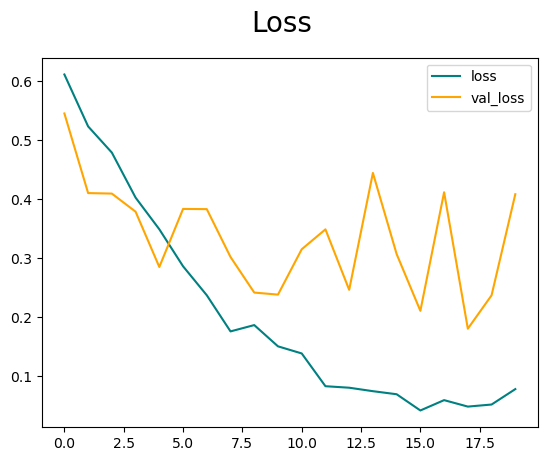

In [33]:
fig = plt.figure()
plt.plot(hist.history["loss"], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper right")
plt.show

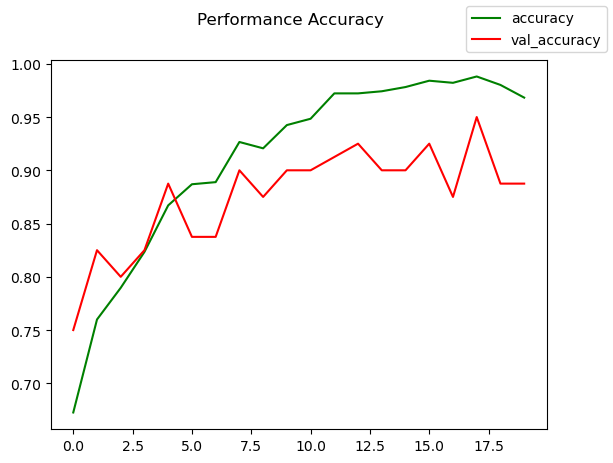

In [34]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color='green', label="accuracy")
plt.plot(hist.history["val_accuracy"], color='red', label="val_accuracy")
fig.suptitle("Performance Accuracy")
fig.legend(loc="upper right")


EVALUATE PERFORMANCE

1. Evaluate 

In [35]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [85]:
len(test)

18

In [37]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

    

2023-12-23 19:34:29.028223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


1/1 [==============================] - 0s 51ms/step


In [38]:
print(f'Precision ; {pre.result().numpy()}, Recall ; {re.result().numpy()}, Accuracy ; {acc.result().numpy()}')

Precision ; 0.8536585569381714, Recall ; 0.760869562625885, Accuracy ; 0.8759124279022217


2. Test

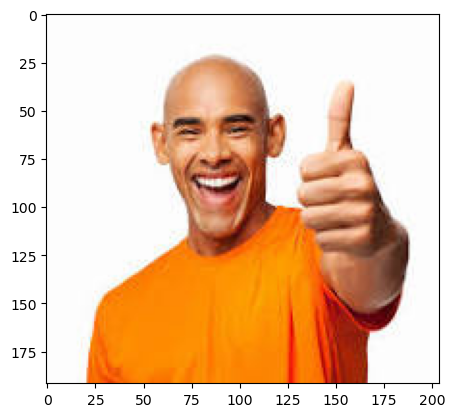

In [41]:
img_test = cv2.imread('test_happy.jpeg')
#plt.imsave(img,)
plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))

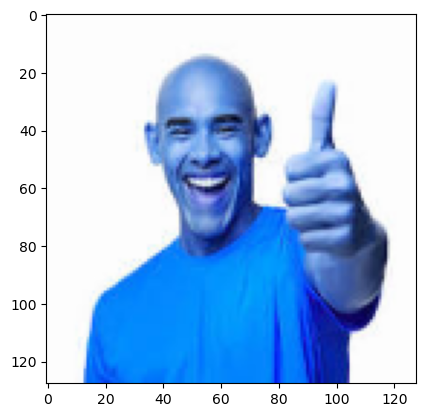

In [44]:
resize = tf.image.resize(img_test, (128,128))
plt.imshow(resize.numpy().astype(int))
#plt.imshow(cv2.cvtColor(resize.numpy(), cv2.COLOR_BGR2RGB))

In [46]:
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 [==============================] - 0s 124ms/step


array([[0.86693615]], dtype=float32)

In [48]:
if yhat > 0.5 :
    print(f'Predicted class is Happy')
else:
    print(f'Predicted class is Sad')

Predicted class is Happy


SAVE THE MODEL

Save the Model

In [49]:
from keras.models import load_model

In [50]:
model.save(os.path.join('models','happysadmodel.h5'))

/home/henock/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [54]:
emotion = new_model.predict(np.expand_dims(resize/255,0))
if emotion > 0.5 :
    print(f'this person is Happy')
else:
    print(f'person person is Sad')

1/1 [==============================] - 0s 174ms/step
this person is Happy
